In [1]:
from quantum_annealing_engine import Coffey, MakeGraphCoffey
import numpy as np

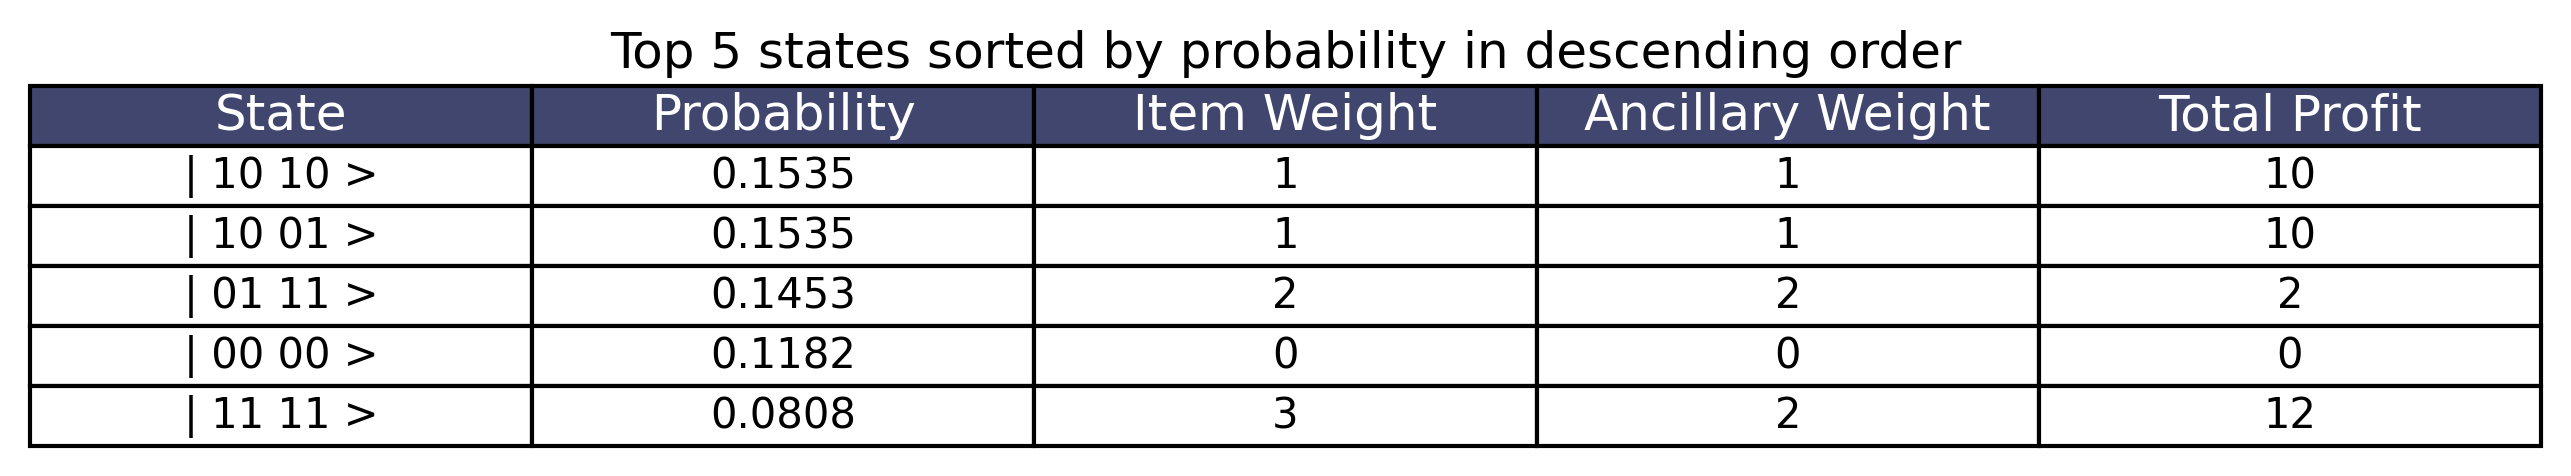

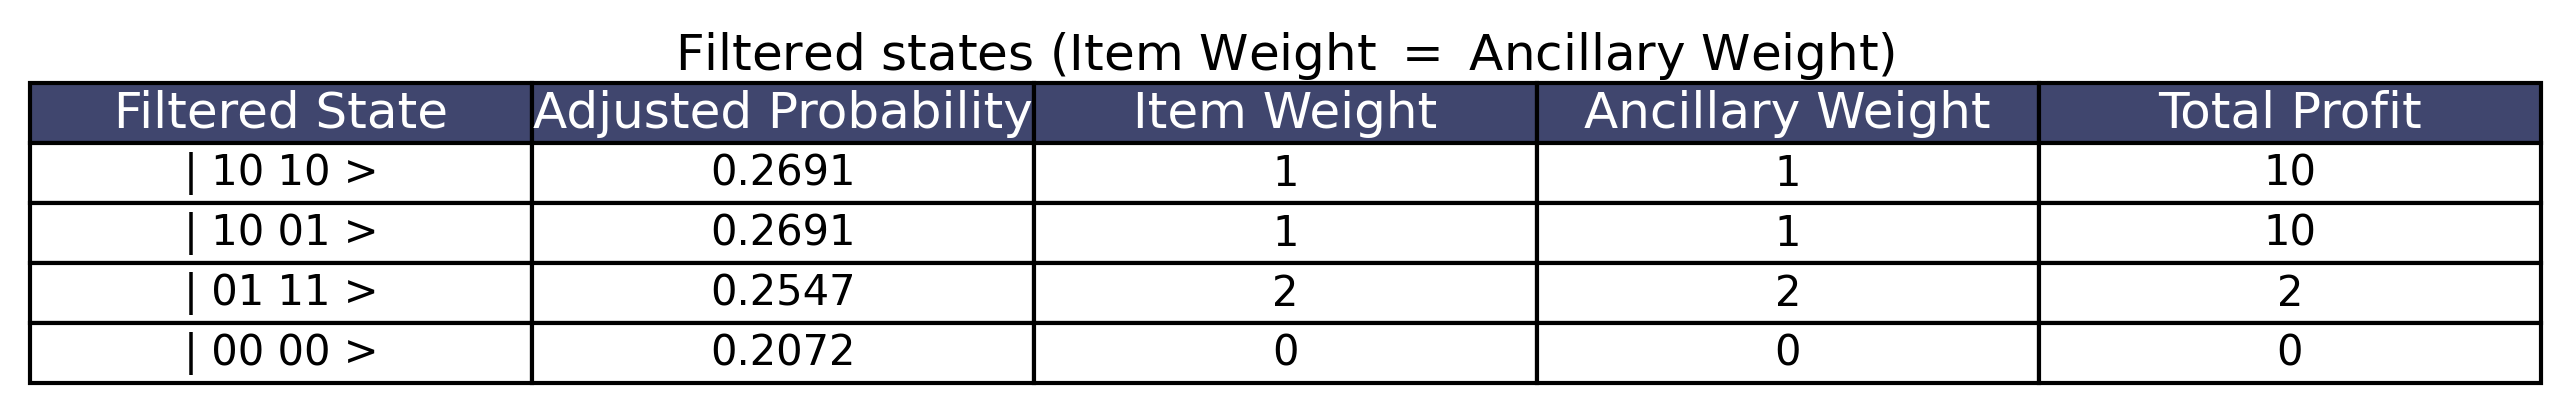

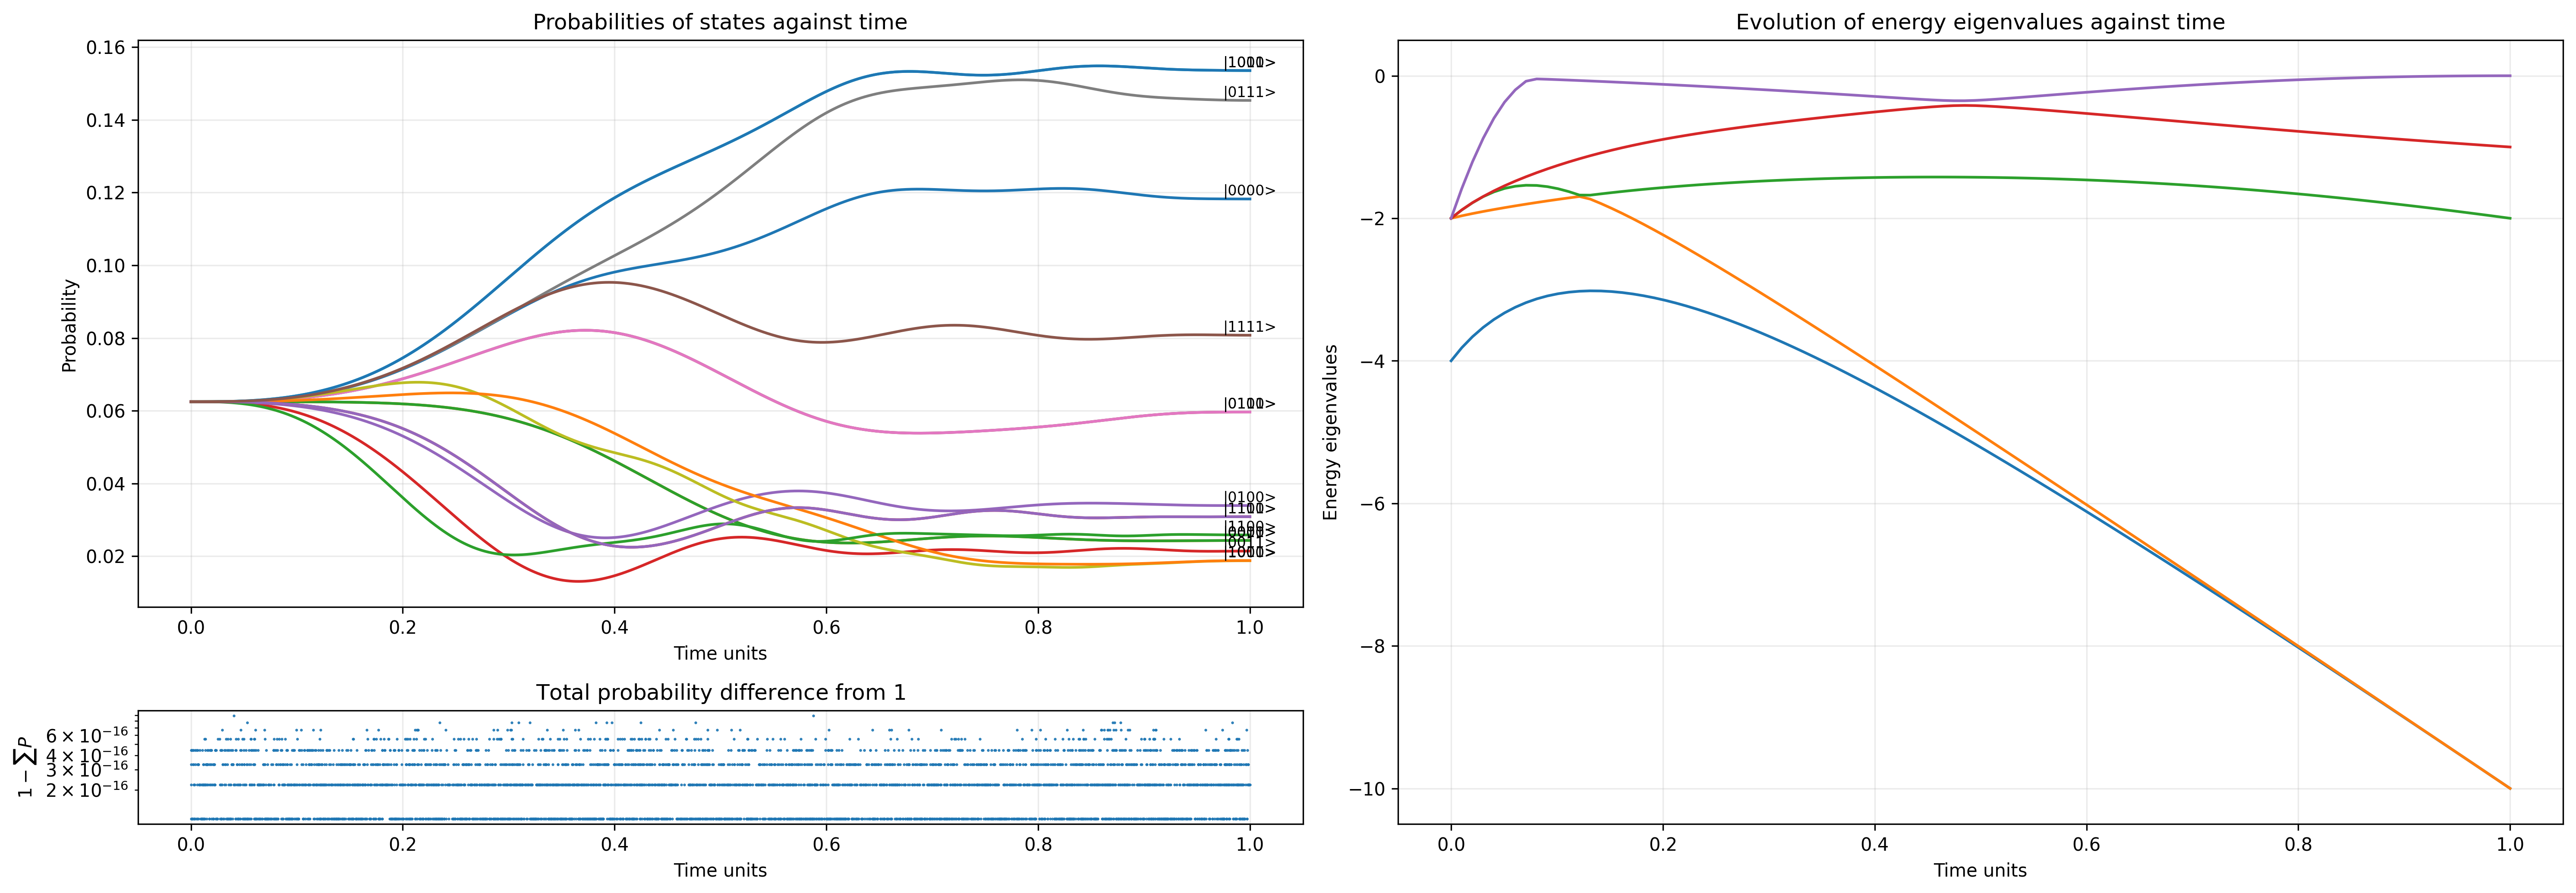

In [ ]:
#   Parameters to set
profits = np.array([10, 2])
weights = np.array([1, 2])
capacity = 2

num_steps = 10000
num_spectrum_steps = 100

sim = Coffey(profits, weights, capacity)

res = sim.anneal(num_steps)
dis = MakeGraphCoffey()
dis.set_probs(sim.compute_probs(res))
dis.set_spectrum(sim.compute_spectrum(num_spectrum_steps))

dis.display_probs(sim)
dis.display_filtered_probs(sim)
dis.display_graph(sim)